In [1]:
from modules.access_sql import AccessSql
import psycopg2
import psycopg2
import rasterio
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from modules.interpolate_geotiffs import InterpolateGeotiffs
import geopandas as gpd
import matplotlib.pyplot as plt


db_connector = cursor = None

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
#This method prints the amount of rows in the agriRef database field_day table.
# The table content was created with colums of name and type:
'''CREATE TABLE IF NOT EXISTS public.field_day (
                    field_id INTEGER, 
                    date DATE,
                    size INTEGER,
                    bbch_phase INTEGER,
                    bbch_sim BOOLEAN,
                    bsc_data raster CONSTRAINT enforce_srid_bsc CHECK (ST_SRID(bsc_data) = 25832),
                    bsc_interp_data raster CONSTRAINT enforce_srid_bsc_interp CHECK (ST_SRID(bsc_interp_data) = 25832),                 
                    bsc_valid BOOLEAN,
                    coh_data raster CONSTRAINT enforce_srid_coh CHECK (ST_SRID(coh_data) = 25832),
                    coh_interp_data raster CONSTRAINT enforce_srid_coh_interp CHECK (ST_SRID(coh_interp_data) = 25832),                     
                    coh_valid BOOLEAN,
                    s2_data raster CONSTRAINT enforce_srid_s2 CHECK (ST_SRID(s2_data) = 25832), 
                    s2_interp_data raster CONSTRAINT enforce_srid_s2_interp CHECK (ST_SRID(s2_interp_data) = 25832), 
                    s2_valid BOOLEAN,
                    temp_min INTEGER,
                    temp_max INTEGER,
                    temp_mean INTEGER,
                    precip INTEGER
                );'''

AccessSql.count_rows_in_table("public.field_day")

Number of rows in 'public.field_day': 179760
PostgreSQL connection is closed


In [10]:
# This is how to connect to the database
try:
    db_connector = psycopg2.connect(database="agriRef", user="postgres", host="localhost",
                                 password="sentinel22", port="5432")

    cursor = db_connector.cursor()
    query = "SET postgis.gdal_enabled_drivers TO 'ENABLE_ALL'"
    cursor.execute(query)

except (Exception, psycopg2.DatabaseError) as error:
    print(error)
finally:
    if db_connector is not None:
        print("DB Connected.")

DB Connected.


In [6]:
%%time
# This is how to fetch a row with a specific id and date
row = AccessSql.fetch_row_from_db(db_connector, "field_c", 352425739918, "2018-01-03")

field_id, date, size, bbch_phase, bbch_sim, bsc_data, bsc_interp_data, bsc_valid, coh_data, coh_interp_data, coh_valid, s2_data, s2_interp_data, s2_valid, temp_min, temp_max, temp_mean, precip = row

print("Field id: " + str(field_id) + ", date: " + str(date) + ", bbch : ", str(bbch_phase) + ", Bsc > 50%: " + str(bsc_valid) +
      ", Coh > 50%: " + str(coh_valid) + ", S2 > 50%: " + str(s2_valid) + ", Temp mean per day: " + str(temp_mean/10) + " % Celcius, Precipitation mean per day: " + str(precip/10) + " mm")

Field id: 352425739918, date: 2018-01-03, bbch :  None, Bsc > 50%: True, Coh > 50%: None, S2 > 50%: None, Temp mean per day: 6.6 % Celcius, Precipitation mean per day: 14.9 mm
CPU times: user 1.03 ms, sys: 528 µs, total: 1.56 ms
Wall time: 33.5 ms


In [ ]:
%%time
filter_bsc = True
filter_coh = True
filter_s2 = True
rows = AccessSql.connect_and_filter_by_complete(filter_bsc, filter_coh, False, False)

In [11]:
#This is how to fetch a row with all relevant data contained

row = AccessSql.fetch_row_from_db(db_connector, "field_c", 352425739918, "2018-01-10")

#print(row)

field_id, date, size, bbch_phase, bbch_sim, bsc_data, bsc_interp_data, bsc_valid, coh_data, coh_interp_data, coh_valid, s2_data, s2_interp_data, s2_valid, temp_min, temp_max, temp_mean, precip = row

print("Field id: " + str(field_id) + ", date: " + str(date) + ", bbch : ", str(bbch_phase) + ", Bsc > 50%: " + str(bsc_valid) +
      ", Coh > 50%: " + str(coh_valid) + ", S2 > 50%: " + str(s2_valid) + ", Temp mean per day: " + str(temp_mean/10) + " % Celcius, Precipitation mean per day: " + str(precip/10) + " mm")

Field id: 352425739918, date: 2018-01-10, bbch :  None, Bsc > 50%: True, Coh > 50%: True, S2 > 50%: True, Temp mean per day: 5.8 % Celcius, Precipitation mean per day: 1.0 mm


Number of bands in image: 2

Image size is: 19 rows x 14 columns

Raster description: (None, None)

Raster driver: GTiff

Image projection:
EPSG:25832 

Image geo-transform:
| 10.00, 0.00, 427698.10|
| 0.00,-10.00, 5589292.53|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 6.905458702346266e-41, 'width': 14, 'height': 19, 'count': 2, 'crs': CRS.from_epsg(25832), 'transform': Affine(10.0, 0.0, 427698.09899809735,
       0.0, -10.0, 5589292.534585598)}




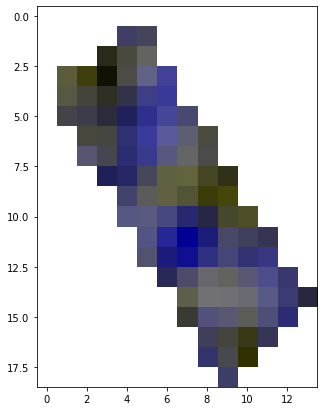

In [12]:
#This plots 1 band of a valid backscatter raster column entry in a row from the table and prints the metadata. 
if row and isinstance(row[5], memoryview):

    # Create an in-memory file with rasterio
    with MemoryFile(row[5].tobytes()) as memfile:
        with memfile.open() as src:

            transform = src.transform
            amount_bands = src.count

            fig, ax = plt.subplots(figsize=(7, 7))

            # This is to print and compare data entered into the DB and retrieved
            InterpolateGeotiffs.print_raster_info(src)

            # Read the 2 bands
            red = src.read(1)
            blue = src.read(2)

            # Normalize the band data to range between 0 and 1
            band1 = InterpolateGeotiffs.normalize_band(red)
            band2 = InterpolateGeotiffs.normalize_band(blue)

            # Create an RGB image where:
            # - Band 1 is used for both the Red and Green channels (to create a grayscale image)
            # - Band 2 is used for the Blue channel (to overlay additional information)
            rgb = np.dstack((band1, band1, band2))

            # Plot the RGB image on the current subplot
            ax.imshow(rgb)

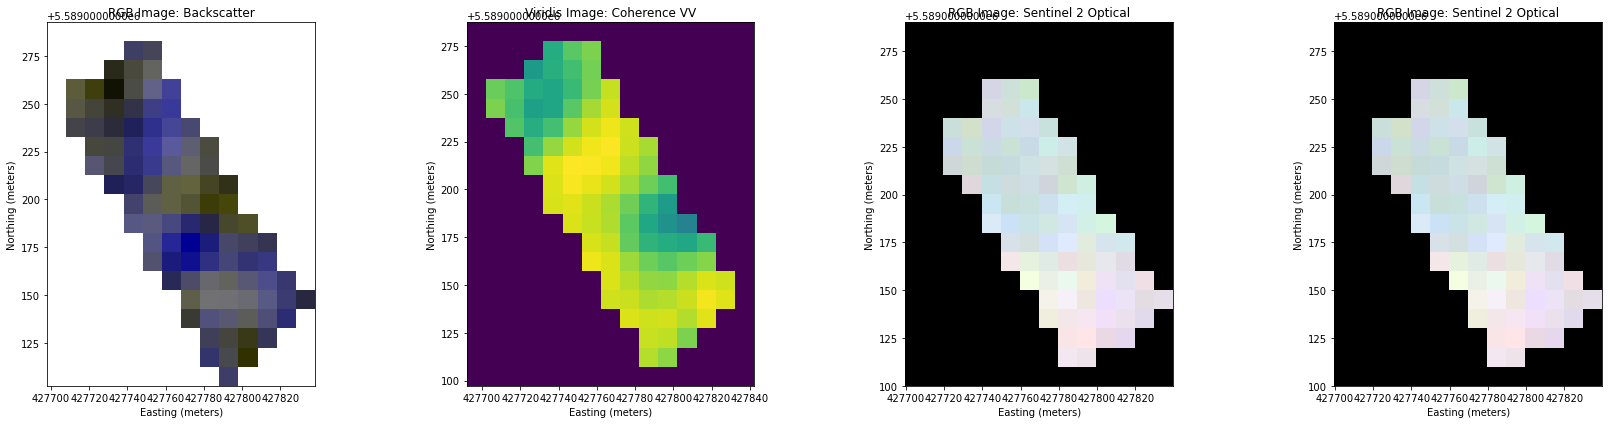

In [13]:
if row and isinstance(row[5], memoryview) and isinstance(row[8], memoryview) and isinstance(row[11], memoryview) and isinstance(row[12], memoryview):

    # Create an in-memory file with rasterio
    with MemoryFile(row[5].tobytes()) as memfile:
        with memfile.open() as bsc:
            with MemoryFile(row[8].tobytes()) as memfile:
                with memfile.open() as coh:
                    with MemoryFile(row[11].tobytes()) as memfile:
                        with memfile.open() as s2:
                            with MemoryFile(row[11].tobytes()) as memfile:
                                with memfile.open() as s2_interp:
                                    InterpolateGeotiffs.plot_multiple_raster([bsc, coh, s2, s2_interp])

In [15]:
#This is to filter the field table by a geojson polygon.

poly = "/media/data_storage_2/jennifer/zepp_field_series_2017-2021/field_series_tests/field_filter_test.geojson"

rows = AccessSql.query_by_geojson_polygon("field", "geom", poly, 25832)
print("Amount rows with geo location in polygon: " + str(len(rows)))

Field id: 17472362, date range: [2017-01-01,2017-12-31], crop type :  W-Raps, size in sqm: 9995
Field id: 17472362, date range: [2016-01-01,2016-12-31], crop type :  W-Raps, size in sqm: 9995
Field id: 18259998, date range: [2017-01-01,2017-12-31], crop type :  W-Raps, size in sqm: 49004
Field id: 17472362, date range: [2018-01-01,2018-12-31], crop type :  W-Raps, size in sqm: 9995
Field id: 18259998, date range: [2018-01-01,2018-12-31], crop type :  W-Raps, size in sqm: 49004
Field id: 18259998, date range: [2016-01-01,2016-12-31], crop type :  W-Raps, size in sqm: 49004
Field id: 18259998, date range: [2015-01-01,2015-12-31], crop type :  W-Raps, size in sqm: 49004
Amount rows with geo location in polygon: 7
